In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np
import datetime
import matplotlib.animation as animation


In [2]:
cfg = {
    "seed": int(np.random.randint(0, 1000, 1)),
    "dataset_size": 2**14,
    "data_dim": 2, 
    "n_dict_ele": 10, # Just for the first. This will change. 
    "batch_size": 128,
    "lr": 1e-2,
    "l1_coeff": 1e-4,
    "num_epochs": 200,
    "dtype": torch.float32,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    "plot_path": "../plots/",
}


/tmp/ipykernel_3192/2850509576.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "seed": int(np.random.randint(0, 1000, 1)),


In [4]:
class SparseAutoEncoder(nn.Module):
    def __init__(self, cfg):
        super().__init__()

        torch.manual_seed(cfg["seed"])

        data_dim = cfg["data_dim"]
        n_dict_ele = cfg["n_dict_ele"]
        l1_coeff = cfg["l1_coeff"]
        dtype = cfg["dtype"]
        
        self.W_enc = nn.Parameter(torch.nn.init.kaiming_uniform_(torch.empty(data_dim, n_dict_ele, dtype=dtype)))
        self.W_dec = nn.Parameter(torch.nn.init.kaiming_uniform_(torch.empty(n_dict_ele, data_dim, dtype=dtype)))
        self.b_enc = nn.Parameter(torch.zeros(n_dict_ele, dtype=dtype))
        self.b_dec = nn.Parameter(torch.zeros(data_dim, dtype=dtype))

        self.W_dec.data[:] = self.W_dec / self.W_dec.norm(dim=-1, keepdim=True)

        self.d_hidden = n_dict_ele
        self.l1_coeff = l1_coeff

        self.to("cuda")

    def forward(self, x):
        x_cent = x# - self.b_dec
        acts = F.relu(x_cent @ self.W_enc + self.b_enc)
        W_dec_normed = self.W_dec / self.W_dec.norm(dim=-1, keepdim=True)
        x_reconstruct = acts @ W_dec_normed + self.b_dec
        l2_loss = (x_reconstruct.float() - x.float()).pow(2).sum(-1).mean(0)
        # get the p norm of the activations
        p_norm = torch.norm(acts, p=0.5, dim=-1)
        
        l1_loss = self.l1_coeff * p_norm.float().sum() #(acts.float().abs().sum())
        loss = l2_loss + l1_loss
        return loss, x_reconstruct, acts, l2_loss, l1_loss



In [5]:
def train_sae(cfg, data):
    # Train the sparse autoencoder to reconstruct the data
    model = SparseAutoEncoder(cfg)
    opt = torch.optim.Adam(model.parameters(), lr=cfg["lr"])
    for epoch in range(cfg["num_epochs"]):
        for i in range(0, cfg["dataset_size"], cfg["batch_size"]):
            opt.zero_grad()
            loss, x_reconstruct, acts, l2_loss, l1_loss = model(data[i:i+cfg["batch_size"]])

            # Keep a running total of the activations for each dictionary element
            total_acts = acts.sum(0)
            loss.backward()
            opt.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: loss {loss.item():.3f}, l2_loss {l2_loss.item():.3f}, l1_loss {l1_loss.item():.3f}")
    return model, total_acts

In [6]:
def plot_model_with_data(model, data, cfg, total_acts, corr):
    # First put the relevant tensors on the CPU
    W_dec_normed = model.W_dec.data.detach().cpu().numpy() / model.W_dec.data.norm(dim=-1, keepdim=True).detach().cpu().numpy()
    b_dec = model.b_dec.detach().cpu().numpy()
    data = data.detach().cpu().numpy()

    # Plot the data with the normed decoder weights and bias overlaid as red arrows and blue arrows respectively
    plt.figure(figsize=(5,5))
    plt.scatter(data[:,0], data[:,1], s=0.5, alpha=0.5)
    plt.scatter(b_dec[0], b_dec[1], s=100, c="b")

    # For each dict element, plot a red arrow from the bias to the dict element. The length of the arrow should
    # be the normalized total activation of that dict element (normalized by max)
    total_acts_normed = total_acts.detach().cpu().numpy() / total_acts.max().detach().cpu().numpy()
    for i in range(W_dec_normed.shape[0]):
        plt.arrow(b_dec[0], b_dec[1], W_dec_normed[i,0] * total_acts_normed[i] , W_dec_normed[i,1] * total_acts_normed[i], color="r", width=0.01)

    # plt.xlim(-6,6)
    # plt.ylim(-6,6)
    # Define unique plot name based on the config and current time
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    plt.savefig(f"{cfg['plot_path']}time{current_time}_dict{cfg['n_dict_ele']}_l1{cfg['l1_coeff']}_seed{cfg['seed']}_corr{str(corr)}_time{current_time}.png")


/tmp/ipykernel_3192/1395771716.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cfg["seed"] = int(np.random.randint(0, 1000, 1))


Epoch 0: loss 2.842, l2_loss 1.529, l1_loss 1.312
Epoch 10: loss 0.955, l2_loss 0.014, l1_loss 0.941
Epoch 20: loss 0.360, l2_loss 0.009, l1_loss 0.351
Epoch 30: loss 0.344, l2_loss 0.008, l1_loss 0.336
Epoch 40: loss 0.320, l2_loss 0.008, l1_loss 0.312
Epoch 50: loss 0.275, l2_loss 0.008, l1_loss 0.267
Epoch 60: loss 0.236, l2_loss 0.018, l1_loss 0.219
Epoch 70: loss 0.191, l2_loss 0.005, l1_loss 0.186
Epoch 80: loss 0.150, l2_loss 0.005, l1_loss 0.146
Epoch 90: loss 0.136, l2_loss 0.003, l1_loss 0.134
Epoch 100: loss 0.132, l2_loss 0.002, l1_loss 0.130
Epoch 110: loss 0.131, l2_loss 0.002, l1_loss 0.129
Epoch 120: loss 0.129, l2_loss 0.002, l1_loss 0.127
Epoch 130: loss 0.128, l2_loss 0.002, l1_loss 0.127
Epoch 140: loss 0.127, l2_loss 0.001, l1_loss 0.126
Epoch 150: loss 0.125, l2_loss 0.002, l1_loss 0.123
Epoch 160: loss 0.121, l2_loss 0.002, l1_loss 0.119
Epoch 170: loss 0.116, l2_loss 0.002, l1_loss 0.115
Epoch 180: loss 0.112, l2_loss 0.002, l1_loss 0.109
Epoch 190: loss 0.108, 

KeyboardInterrupt: 

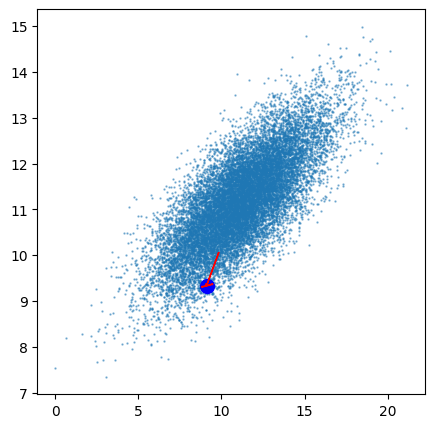

In [7]:
# Multiple plots for both isotropic and correlated data
for i in range(6):
    cfg["seed"] = int(np.random.randint(0, 1000, 1))
    # data = torch.randn(cfg["dataset_size"], cfg["data_dim"]).to(cfg["device"])
    # data = data - data.min()
    # model, total_acts = train_sae(cfg, data)
    # plot_model_with_data(model, data, cfg, total_acts, corr=False)

    data = torch.randn(cfg["dataset_size"], cfg["data_dim"]).to(cfg["device"]) @ torch.randn(cfg["data_dim"], cfg["data_dim"]).to(cfg["device"])
    data = data - data.min()
    model, total_acts = train_sae(cfg, data)
    plot_model_with_data(model, data, cfg, total_acts, corr=True)

In [ ]:
# Now we do similar functions but for 3D data. We'll need the 3D plot to rotate and save as a gif


def plot_model_with_data_3d(model, data, cfg, total_acts, corr):
    # First put the relevant tensors on the CPU
    W_dec_normed = model.W_dec.data.detach().cpu().numpy() / model.W_dec.data.norm(dim=-1, keepdim=True).detach().cpu().numpy()
    b_dec = model.b_dec.detach().cpu().numpy()
    data = data.detach().cpu().numpy()
    data_mean = data.mean(axis=0)

    # Plot the data with the normed decoder weights and bias overlaid as red arrows and blue arrows respectively
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(data[:, 0], data[:, 1], data[:, 2], s=0.5, alpha=0.05)
    ax.scatter(b_dec[0], b_dec[1], b_dec[2], s=10, c="b")
    ax.scatter(data_mean[0], data_mean[1], data_mean[2], s=10, c="g")

    # For each dict element, plot a red arrow from the bias to the dict element
    # The length of the arrow should be the normalized total activation of that dict element (normalized by max)
    total_acts_normed = total_acts.detach().cpu().numpy() / total_acts.max().detach().cpu().numpy()

    arrows = []
    for i in range(W_dec_normed.shape[0]):
        scale = total_acts_normed[i] * 2
        arrow = ax.quiver(b_dec[0], b_dec[1], b_dec[2], W_dec_normed[i, 0] * scale, W_dec_normed[i, 1] * scale, W_dec_normed[i, 2] * scale, color="r", alpha=1.0)  # Increase alpha value for more visibility

    # ax.set_xlim(-6, 6)
    # ax.set_ylim(-6, 6)
    # ax.set_zlim(-6, 6)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Define unique plot name based on the config and current time
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    plt.savefig(f"{cfg['plot_path']}dict{cfg['n_dict_ele']}_l1{cfg['l1_coeff']}_seed{cfg['seed']}_corr{str(corr)}_time{current_time}.png")

    # Create animation
    def update(frame):
        ax.view_init(elev=10, azim=frame)
    
    ani = animation.FuncAnimation(fig, update, frames=np.arange(0, 360, 10), interval=100)
    ani.save(f"{cfg['plot_path']}gif_time{current_time}_dict{cfg['n_dict_ele']}_l1{cfg['l1_coeff']}_seed{cfg['seed']}_corr{str(corr)}.gif", writer='imagemagick')


In [ ]:
cfg["data_dim"] = 3
cfg["n_dict_ele"] = 10
cfg["num_epochs"] = 200



/tmp/ipykernel_5419/3315966270.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cfg["seed"] = int(np.random.randint(0, 1000, 1))


Epoch 0: loss 6.962, l2_loss 5.062, l1_loss 1.900
Epoch 10: loss 0.909, l2_loss 0.090, l1_loss 0.819
Epoch 20: loss 0.719, l2_loss 0.100, l1_loss 0.619
Epoch 30: loss 0.626, l2_loss 0.082, l1_loss 0.544
Epoch 40: loss 0.533, l2_loss 0.046, l1_loss 0.488
Epoch 50: loss 0.480, l2_loss 0.011, l1_loss 0.469
Epoch 60: loss 0.461, l2_loss 0.010, l1_loss 0.451
Epoch 70: loss 0.432, l2_loss 0.010, l1_loss 0.422
Epoch 80: loss 0.385, l2_loss 0.009, l1_loss 0.376
Epoch 90: loss 0.314, l2_loss 0.007, l1_loss 0.306
Epoch 100: loss 0.302, l2_loss 0.045, l1_loss 0.257
Epoch 110: loss 0.277, l2_loss 0.049, l1_loss 0.227
Epoch 120: loss 0.259, l2_loss 0.029, l1_loss 0.230
Epoch 130: loss 0.254, l2_loss 0.028, l1_loss 0.225
Epoch 140: loss 0.251, l2_loss 0.027, l1_loss 0.224
Epoch 150: loss 0.248, l2_loss 0.028, l1_loss 0.221
Epoch 160: loss 0.247, l2_loss 0.025, l1_loss 0.222
Epoch 170: loss 0.246, l2_loss 0.028, l1_loss 0.218
Epoch 180: loss 0.244, l2_loss 0.028, l1_loss 0.216
Epoch 190: loss 0.243, 

MovieWriter imagemagick unavailable; using Pillow instead.
/tmp/ipykernel_5419/3315966270.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cfg["seed"] = int(np.random.randint(0, 1000, 1))


Epoch 0: loss 2.471, l2_loss 1.328, l1_loss 1.143
Epoch 10: loss 0.942, l2_loss 0.133, l1_loss 0.809
Epoch 20: loss 0.648, l2_loss 0.089, l1_loss 0.559
Epoch 30: loss 0.387, l2_loss 0.017, l1_loss 0.370
Epoch 40: loss 0.344, l2_loss 0.007, l1_loss 0.338
Epoch 50: loss 0.311, l2_loss 0.009, l1_loss 0.302
Epoch 60: loss 0.245, l2_loss 0.016, l1_loss 0.229
Epoch 70: loss 0.129, l2_loss 0.031, l1_loss 0.098
Epoch 80: loss 0.112, l2_loss 0.030, l1_loss 0.082
Epoch 90: loss 0.108, l2_loss 0.026, l1_loss 0.082
Epoch 100: loss 0.105, l2_loss 0.021, l1_loss 0.084
Epoch 110: loss 0.102, l2_loss 0.018, l1_loss 0.085
Epoch 120: loss 0.104, l2_loss 0.020, l1_loss 0.085
Epoch 130: loss 0.100, l2_loss 0.015, l1_loss 0.085
Epoch 140: loss 0.100, l2_loss 0.017, l1_loss 0.083
Epoch 150: loss 0.100, l2_loss 0.018, l1_loss 0.082
Epoch 160: loss 0.099, l2_loss 0.015, l1_loss 0.083
Epoch 170: loss 0.098, l2_loss 0.015, l1_loss 0.083
Epoch 180: loss 0.098, l2_loss 0.015, l1_loss 0.083
Epoch 190: loss 0.100, 

MovieWriter imagemagick unavailable; using Pillow instead.
/tmp/ipykernel_5419/3315966270.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cfg["seed"] = int(np.random.randint(0, 1000, 1))


Epoch 0: loss 7.160, l2_loss 2.815, l1_loss 4.345
Epoch 10: loss 1.987, l2_loss 0.048, l1_loss 1.938
Epoch 20: loss 1.114, l2_loss 0.109, l1_loss 1.006
Epoch 30: loss 0.662, l2_loss 0.047, l1_loss 0.615
Epoch 40: loss 0.607, l2_loss 0.058, l1_loss 0.549
Epoch 50: loss 0.496, l2_loss 0.071, l1_loss 0.424
Epoch 60: loss 0.399, l2_loss 0.048, l1_loss 0.351
Epoch 70: loss 0.365, l2_loss 0.050, l1_loss 0.314
Epoch 80: loss 0.327, l2_loss 0.052, l1_loss 0.276
Epoch 90: loss 0.292, l2_loss 0.052, l1_loss 0.240
Epoch 100: loss 0.263, l2_loss 0.052, l1_loss 0.211
Epoch 110: loss 0.245, l2_loss 0.051, l1_loss 0.193
Epoch 120: loss 0.236, l2_loss 0.047, l1_loss 0.189
Epoch 130: loss 0.233, l2_loss 0.045, l1_loss 0.188
Epoch 140: loss 0.232, l2_loss 0.044, l1_loss 0.188
Epoch 150: loss 0.231, l2_loss 0.045, l1_loss 0.187
Epoch 160: loss 0.231, l2_loss 0.046, l1_loss 0.186
Epoch 170: loss 0.230, l2_loss 0.044, l1_loss 0.186
Epoch 180: loss 0.229, l2_loss 0.045, l1_loss 0.183
Epoch 190: loss 0.229, 

MovieWriter imagemagick unavailable; using Pillow instead.
/tmp/ipykernel_5419/3315966270.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cfg["seed"] = int(np.random.randint(0, 1000, 1))


Epoch 0: loss 1.875, l2_loss 1.064, l1_loss 0.812
Epoch 10: loss 0.447, l2_loss 0.030, l1_loss 0.417
Epoch 20: loss 0.326, l2_loss 0.012, l1_loss 0.314
Epoch 30: loss 0.259, l2_loss 0.018, l1_loss 0.241
Epoch 40: loss 0.167, l2_loss 0.011, l1_loss 0.155
Epoch 50: loss 0.063, l2_loss 0.006, l1_loss 0.057
Epoch 60: loss 0.062, l2_loss 0.007, l1_loss 0.055
Epoch 70: loss 0.062, l2_loss 0.007, l1_loss 0.055
Epoch 80: loss 0.062, l2_loss 0.006, l1_loss 0.055
Epoch 90: loss 0.062, l2_loss 0.007, l1_loss 0.055
Epoch 100: loss 0.062, l2_loss 0.007, l1_loss 0.055
Epoch 110: loss 0.062, l2_loss 0.007, l1_loss 0.055
Epoch 120: loss 0.061, l2_loss 0.006, l1_loss 0.056
Epoch 130: loss 0.062, l2_loss 0.007, l1_loss 0.055
Epoch 140: loss 0.062, l2_loss 0.007, l1_loss 0.055
Epoch 150: loss 0.062, l2_loss 0.006, l1_loss 0.055
Epoch 160: loss 0.063, l2_loss 0.009, l1_loss 0.054
Epoch 170: loss 0.062, l2_loss 0.007, l1_loss 0.055
Epoch 180: loss 0.061, l2_loss 0.006, l1_loss 0.055
Epoch 190: loss 0.061, 

MovieWriter imagemagick unavailable; using Pillow instead.
/tmp/ipykernel_5419/3315966270.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cfg["seed"] = int(np.random.randint(0, 1000, 1))


Epoch 0: loss 0.509, l2_loss 0.130, l1_loss 0.378
Epoch 10: loss 0.290, l2_loss 0.023, l1_loss 0.267
Epoch 20: loss 0.242, l2_loss 0.016, l1_loss 0.226
Epoch 30: loss 0.172, l2_loss 0.013, l1_loss 0.159
Epoch 40: loss 0.164, l2_loss 0.033, l1_loss 0.131
Epoch 50: loss 0.173, l2_loss 0.046, l1_loss 0.127
Epoch 60: loss 0.178, l2_loss 0.052, l1_loss 0.126
Epoch 70: loss 0.181, l2_loss 0.059, l1_loss 0.122
Epoch 80: loss 0.177, l2_loss 0.057, l1_loss 0.120
Epoch 90: loss 0.173, l2_loss 0.052, l1_loss 0.120
Epoch 100: loss 0.168, l2_loss 0.051, l1_loss 0.117
Epoch 110: loss 0.163, l2_loss 0.048, l1_loss 0.115
Epoch 120: loss 0.157, l2_loss 0.045, l1_loss 0.112
Epoch 130: loss 0.150, l2_loss 0.040, l1_loss 0.110
Epoch 140: loss 0.145, l2_loss 0.035, l1_loss 0.110
Epoch 150: loss 0.138, l2_loss 0.031, l1_loss 0.107
Epoch 160: loss 0.132, l2_loss 0.027, l1_loss 0.105
Epoch 170: loss 0.190, l2_loss 0.115, l1_loss 0.075
Epoch 180: loss 0.186, l2_loss 0.113, l1_loss 0.073
Epoch 190: loss 0.183, 

MovieWriter imagemagick unavailable; using Pillow instead.
/tmp/ipykernel_5419/3315966270.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cfg["seed"] = int(np.random.randint(0, 1000, 1))


Epoch 0: loss 0.752, l2_loss 0.207, l1_loss 0.544
Epoch 10: loss 0.297, l2_loss 0.012, l1_loss 0.286
Epoch 20: loss 0.149, l2_loss 0.017, l1_loss 0.132
Epoch 30: loss 0.116, l2_loss 0.009, l1_loss 0.106
Epoch 40: loss 0.101, l2_loss 0.014, l1_loss 0.087
Epoch 50: loss 0.062, l2_loss 0.008, l1_loss 0.054
Epoch 60: loss 0.053, l2_loss 0.010, l1_loss 0.043
Epoch 70: loss 0.052, l2_loss 0.008, l1_loss 0.043
Epoch 80: loss 0.051, l2_loss 0.007, l1_loss 0.043
Epoch 90: loss 0.050, l2_loss 0.006, l1_loss 0.043
Epoch 100: loss 0.049, l2_loss 0.006, l1_loss 0.043
Epoch 110: loss 0.049, l2_loss 0.005, l1_loss 0.044
Epoch 120: loss 0.048, l2_loss 0.005, l1_loss 0.044
Epoch 130: loss 0.048, l2_loss 0.004, l1_loss 0.044
Epoch 140: loss 0.048, l2_loss 0.004, l1_loss 0.043
Epoch 150: loss 0.048, l2_loss 0.004, l1_loss 0.044
Epoch 160: loss 0.047, l2_loss 0.004, l1_loss 0.043
Epoch 170: loss 0.047, l2_loss 0.004, l1_loss 0.043
Epoch 180: loss 0.047, l2_loss 0.004, l1_loss 0.043
Epoch 190: loss 0.047, 

MovieWriter imagemagick unavailable; using Pillow instead.


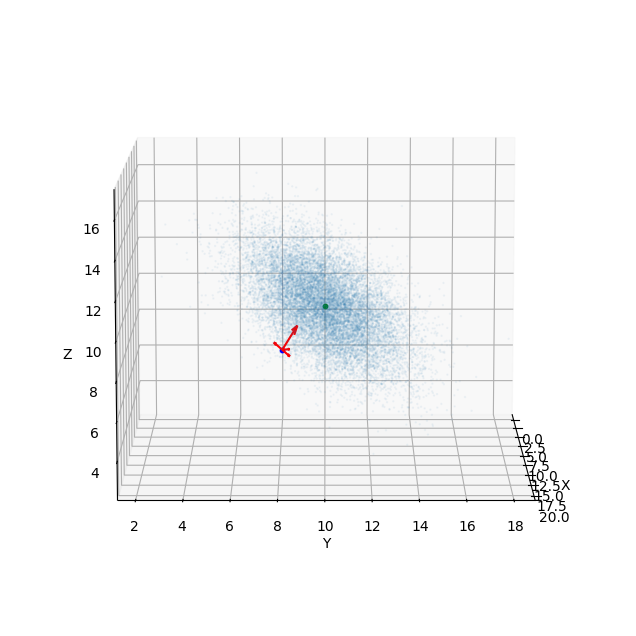

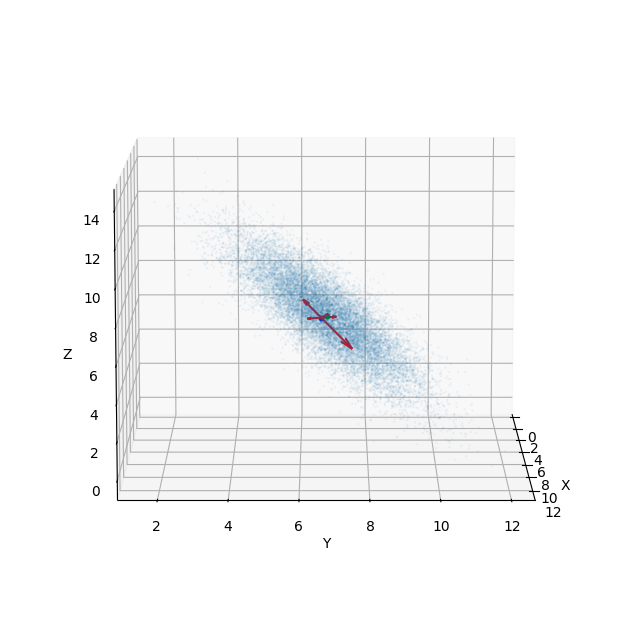

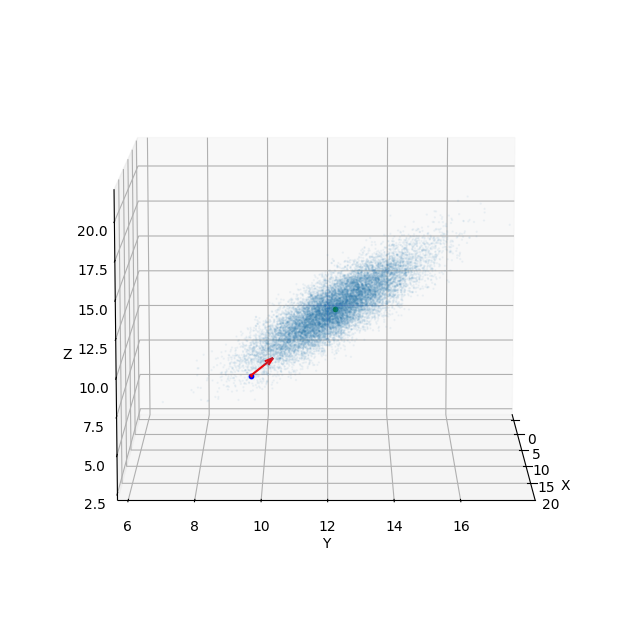

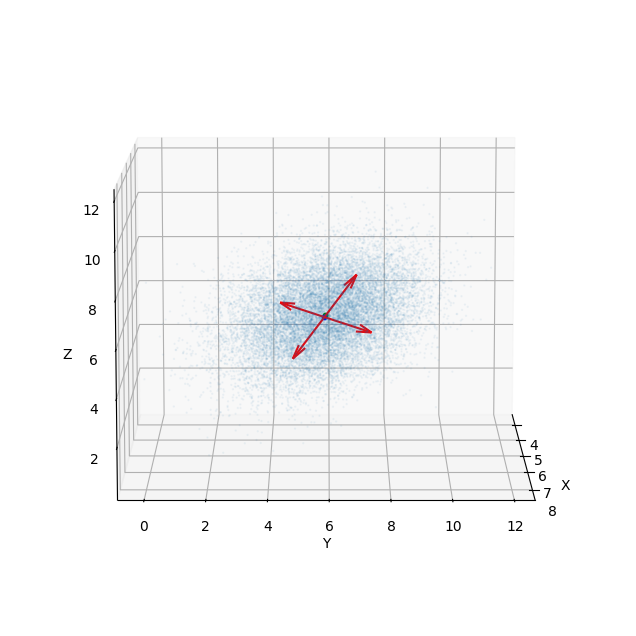

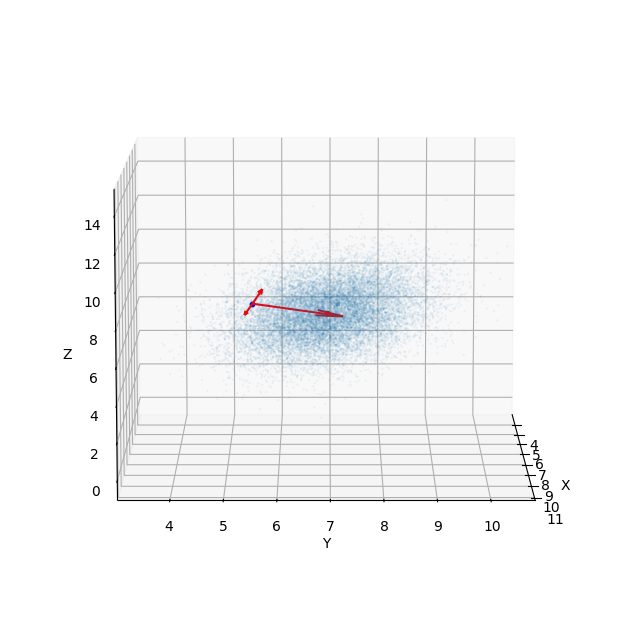

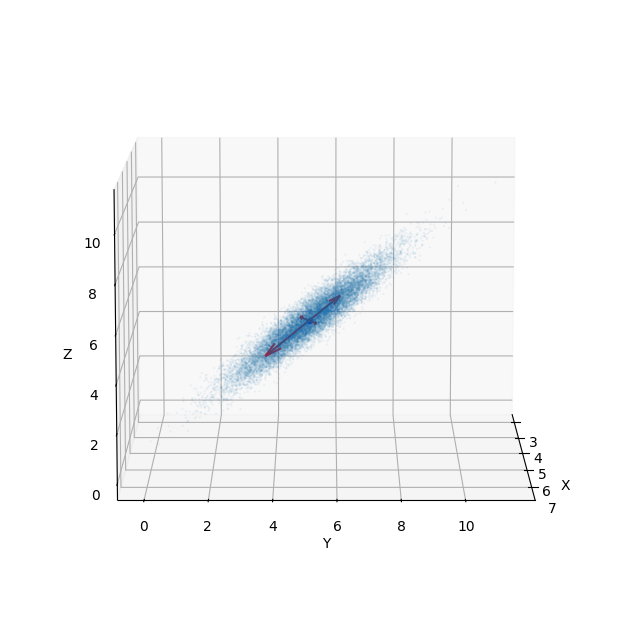

In [ ]:
# Now do multiple plots for both isotropic and correlated data as before but now for 3d data

for i in range(6):
    cfg["seed"] = int(np.random.randint(0, 1000, 1))
    # data = torch.randn(cfg["dataset_size"], cfg["data_dim"]).to(cfg["device"])
    # data = data - data.min()
    # model, total_acts = train_sae(cfg, data)
    # plot_model_with_data_3d(model, data, cfg, total_acts, corr=False)

    data = torch.randn(cfg["dataset_size"], cfg["data_dim"]).to(cfg["device"]) @ torch.randn(cfg["data_dim"], cfg["data_dim"]).to(cfg["device"])
    data = data - data.min()
    model, total_acts = train_sae(cfg, data)
    plot_model_with_data_3d(model, data, cfg, total_acts, corr=True)